# Part 05 - Pandas applied for stock market analysis

One of the most interesting uses of python is as a data analysis system. Its plotting tools are top notch and along with libraries such as pandas there are a wealth of statistical analysis tools available.

For a more complete look at data analysis using pandas, see [this example working through earth science data](https://www.scipy-lectures.org/intro/scipy.html#statistics-and-random-numbers-scipy-stats). I have a personal interest in stocks and shares and I'm a avid fan of SpaceX and Tesla, so lets look at some data on Tesla.

In [11]:
# Pandas is like a programmable spreadsheet, you have named columns of data and an index
import pandas as pd
# This next line is needed to fix a current bug in pandas_datareader
pd.core.common.is_list_like = pd.api.types.is_list_like
# Pandas datareader is an interface to lots of kinds of sources of data, including stocks
import pandas_datareader.data as web

# It should be noted that Pandas datareader for stock information breaks all the time,
# all I can promise is that this works today, 6th July 2018

# Websites limit the rate at which you can download stock data. Here we check if we've
# already downloaded the data and pickled it as "stock_data.p"
import pickle
import os.path
if not os.path.isfile("stock_data.p"):
    # OK we've not downloaded it yet, download the data then pickle it
    
    # Let's get Tesla stock data; Tesla's ticker symbol is TSLA on the US NASDAQ exchange
    # First argument is the series we want, second is the source ("stooq" works at the moment)
    tesla = web.DataReader("TSLA", "yahoo")

    # We'll also extract the Standard & Poor 500 index (sum of the top 500 companies)
    spx = web.DataReader("^GSPC", "yahoo")
    
    pickle.dump([tesla, spx], open("stock_data.p", "wb"))
else:
    # We've already downloaded it, just unpickle it
    tesla, spx = pickle.load(open("stock_data.p", "rb"))

#What kind of data did we get? Lets print the header of the table and the first few rows
print(tesla.tail())

                  High         Low        Open       Close   Volume   Adj Close
Date                                                                           
2019-06-25  225.339996  219.490005  224.389999  219.759995  6182100  219.759995
2019-06-26  227.229996  218.100006  220.309998  219.270004  8507200  219.270004
2019-06-27  222.899994  217.350006  219.449997  222.839996  6339700  222.839996
2019-06-28  225.169998  220.800003  220.990005  223.460007  6851400  223.460007
2019-07-01  233.100006  226.279999  230.210007  227.169998  8213400  227.169998


Great, opening and closing prices as well as daily highs/lows and the volume of stocks traded, all indexed by the date of the information. Notice that some dates are missing (weekends/holidays).

We need a basis for comparison for the performance of an individiual stock, so we also downloaded the S&P 500 index (the average of the 500 largest companies on the index).

In [12]:
print(spx.tail())

                   High          Low  ...      Volume    Adj Close
Date                                  ...                         
2019-06-25  2946.520020  2916.010010  ...  3578050000  2917.379883
2019-06-26  2932.590088  2912.989990  ...  3478130000  2913.780029
2019-06-27  2929.300049  2918.570068  ...  3122920000  2924.919922
2019-06-28  2943.979980  2929.050049  ...  5420700000  2941.760010
2019-07-01  2977.929932  2952.219971  ...  3513270000  2964.330078

[5 rows x 6 columns]


OK, let's try plotting the data and comparing tesla versus the index,

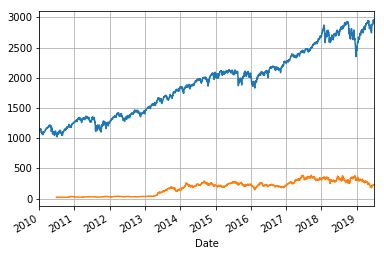

In [13]:
%matplotlib inline
#Pandas has its own built in support for matplotlib:
spx["Close"].plot(grid = True) # Plot the adjusted closing price of AAPL
tesla["Close"].plot(grid = True) # Plot the adjusted closing price of AAPL

Hmmmm... Lets filter that data, only taking back as far as the start of 2016, here we see the power of pandas' slicing,

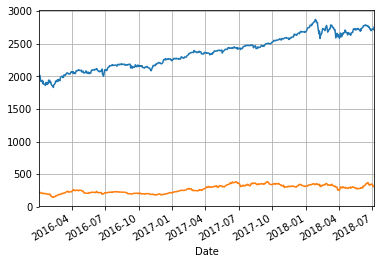

In [17]:
import datetime
start = datetime.datetime(2016,1,1)
end = datetime.datetime(2018,7,6)
spx.loc[start:end]["Close"].plot(grid = True)
tesla.loc[start:end]["Close"].plot(grid = True)

Hmm still not a good comparison due to the differing scale of the symbols, lets try normalising both curves by today's value,

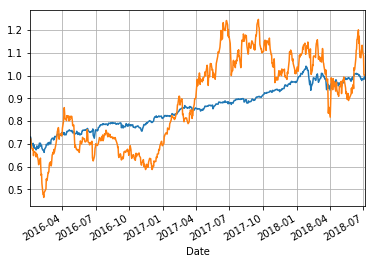

In [24]:
(spx.loc[start:end]["Close"]/spx.loc[end]["Close"]).plot(grid = True)
(tesla.loc[start:end]["Close"]/tesla.loc[end]["Close"]).plot(grid = True)

Nice! Pandas lets us just divide lists of data by scalars by just applying the division element-wise across the array. I didn't know it could do this, I just tried the simplest thing and it worked. Python libraries are terrific at Just Working&trade;. We can see that over this time period, Tesla actually performed almost exactly to market average but with significantly higher volatility...

Let's actually normalise to the S&P 500 index every day (instead of just the value today), to see the fluctuation around the index a bit clearer,

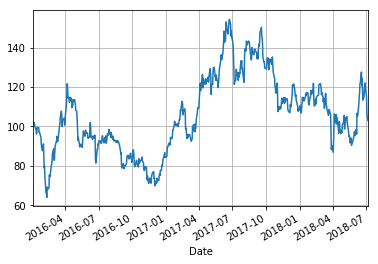

In [25]:
data = tesla.loc[start:end]["Close"]/spx.loc[start:end]["Close"]*spx.iloc[0]["Close"] - tesla.iloc[0]["Close"]
data.plot(grid = True)

Warren Buffet (famous american investor, 3rd wealthiest person in the world), made a  \$1M bet that a low-cost S&P 500 index tracker (simple fund that invests in all the companies in the index) would outperform highly managed index funds over 10 years. He won this bet when the index tracker made 7% annual and the hedge funds made 2.2%. 

This is anecdotal evidence that even stocks that have performed amazingly at times (like tesla) still average out to the index.

Of course, this is not investment advice or even a particularly detailed one; however, it shows just how easy it is to get data into python and hack something interesting out of it. 

## Extra credit

For more information on analysing data sets, see this earth science example mentioned in the introduction:
http://earthpy.org/pandas-basics.html


- What day of the week is the best day to buy stocks? Just take all data for the week, normalise it by Monday's value, and then plot the average value over the rest of the week.
- Extend this to months. Are there annual cycles? Can you find the patterns to the stock market? Watch out for red herrings, like stock prices dropping as soon as the company issues a dividend. If you solve this one, there's many bankers who want to talk to you...